<a href="https://colab.research.google.com/github/deding2000/COMP5329_Ass2/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Not needed before we upload files to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
from google.colab import files
uploaded = files.upload() # select all python files from the github page and kaggle.json

Saving metrics.py to metrics.py
Saving utils.py to utils.py


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'multi-label-classification-competition-2025'
! mkdir Dataset
! unzip multi-label-classification-competition-2025.zip -d Dataset &> /dev/null

Streaming af output blev afkortet til de sidste 5000 linjer.
  inflating: Dataset/COMP5329S1A2Dataset/data/550.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5500.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5501.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5502.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5503.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5504.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5505.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5506.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5507.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5508.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5509.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/551.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5510.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5511.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5512.jpg  
  inflating: Dataset/COMP5329S1A2Dataset/data/5513.jpg  
  inflating: Dataset/COMP5329

In [25]:
# Model arcitechture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()  # Compulsory operation.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64,3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(3,stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout3d(1-0.9)
        self.dropout2 = nn.Dropout3d(1-0.75)
        self.dropout3 = nn.Dropout(1-0.5)
        self.fc1 = nn.Linear(14400, 1000)
        self.fc2 = nn.Linear(1000, 19)

    def forward(self, x):
        x = self.dropout1(x)
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.dropout2(x)
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.dropout2(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        logits = self.fc2(x)
        return logits

In [27]:
from sklearn.metrics import confusion_matrix
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


def train_iter(log_interval, model, device, optimizer, loss_func, data, target):
    '''
    Train the model for a single iteration.
    An iteration is when a single batch of data is passed forward and
    backward through the neural network.
    '''
    data, target = data.to(device), target.to(device)  # Move this batch of data to the specified device.
    optimizer.zero_grad()  # Zero out the old gradients (so we only use new gradients for a new update iteration).
    output = model(data)  # Forward the data through the model.
    loss = loss_func(output, target.float())  # Calculate the loss
    loss.backward()  # Backward the loss and calculate gradients for parameters.
    optimizer.step()  # Update the parameters.
    return loss

def train_epoch(log_interval, model, device, train_loader, optimizer, epoch, loss_func):
    '''
    Train the model for an epoch.
    An epoch is when the entire dataset is passed forward and
    backward through the neural network for once.
    The number of batches in a dataset is equal to number of iterations for one epoch.
    '''
    model.train()
    losses = 0
    for batch_idx, (data, target) in enumerate(train_loader):  # Iterate through the entire dataset to form an epoch.
        loss = train_iter(log_interval, model, device, optimizer, loss_func, data, target)  # Train for an iteration.
        losses += loss.item()
        if batch_idx % log_interval == 0:
            print('\nTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses/len(train_loader)

def train_network(log_interval,model, device, train_loader, test_loader,optimizer, loss,epochs=10):
    train_losses = []
    test_losses = []
    for epoch in tqdm(range(epochs)):
        train_loss = train_epoch(log_interval, model, device, train_loader, optimizer, epoch, loss)
        if test_loader:
            test_loss, _, _ = test(model,device,test_loader,loss_func=loss,target_available=True)
            test_losses.append(test_loss)

        train_losses.append(train_loss)
    if test_loader:
        return train_losses, test_losses
    else:
        return train_losses

def test(model, device, test_loader, loss_func,target_available=True,verbose=False):
    '''
    Testing the model on the test set and compute metrics.
    '''
    model.eval()  # Switch the model to evaluation mode, which prevents the dropout behavior.
    sigmoid_fun = torch.nn.Sigmoid()
    all_preds = []
    all_targets = []
    if target_available:
        test_loss = 0
        tp = 0 # True positives
        fp = 0 # False positives
        fn = 0 # False negatives
        with torch.no_grad():  # Because this is testing and no optimization is required, the gradients are not needed.
            for data, target in (test_loader):  # Iterate through the entire test set.
                data, target = data.to(device), target.to(device)  # Move this batch of data to the specified device.
                all_targets.append(target.float())
                output = model(data)  # Forward the data through the model.
                test_loss += target.size(0)*loss_func(output, target.float()).item()  # Sum up batch loss
                pred = torch.where(sigmoid_fun(output) >= 0.5, 1, 0)  # Get predictions in right format
                all_preds.append(pred)
                tp_temp = (pred*target).sum().item()
                fp_temp = (torch.maximum(pred-target,torch.zeros_like(pred))).sum().item()
                fn_temp = (torch.maximum(target-pred,torch.zeros_like(pred))).sum().item()
                #_, fp_temp, fn_temp, tp_temp = confusion_matrix(target.view_as(pred), pred).ravel() # Get relevant counts for F1 Score
                tp += tp_temp
                fp += fp_temp
                fn += fn_temp

        test_loss /= len(test_loader.dataset)  # Average the loss on the entire testing set.
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        F1 = (2*precision*recall)/(precision + recall) # Compute final F1 Score
        if verbose:
            print('\nTest set results: Average loss: {:.4f}, F1 Score: {:.2f}\n'.format(
                test_loss, F1))
        return test_loss, all_preds, all_targets
    else:
        for data, _ in tqdm(test_loader):  # Iterate through the entire test set.
            data = data.to(device)  # Move this batch of data to the specified device.
            output = model(data)  # Forward the data through the model.
            pred = torch.where(sigmoid_fun(output) >= 0.5, 1, 0)  # Get predictions in right format
            all_preds.append(pred)

        print('\nPredictions computed for test set.')
        return all_preds

def pos_weight(df_train,barplot=False):

    n = len(df_train)
    count=np.zeros(19)
    pos_weight=np.zeros(19)

    for i in range(n):
        labels = list(map(int,df_train.iloc[i,1].split(" ")))
        for j in range(19):
            count[j] = count[j]+labels.count(j+1)
            if count[j]:
                pos_weight[j]=(n-count[j])/count[j]
            else:
                pos_weight[j]=0


    names = np.arange(1,20)

    # calculate weights for the loss function
    #pos_weight  = (n - count) / count
    #pos_weight[11] = 0 # Remove class 12
    if barplot:
        plt.bar(names,count)
        plt.show()

    return torch.as_tensor(pos_weight)

In [28]:
import torch
import numpy as np

#function for performance evaluation metrics

def recall(pred,target):
    tp = (pred*target).sum().item()
    fn = (np.maximum(target-pred,np.zeros_like(pred))).sum().item()

    recall = tp/(tp+fn)
    return recall

def precision(pred,target):
    tp = (pred*target).sum().item()
    fp = (np.maximum(pred-target,np.zeros_like(pred))).sum().item()

    precision = tp/(tp+fp)
    return precision

def accuracy(pred,target):
    tp = (pred*target).sum().item()
    fp = (np.maximum(pred-target,np.zeros_like(pred))).sum().item()
    fn = (np.maximum(target-pred,np.zeros_like(pred))).sum().item()
    tn = len(pred)*19 - (tp + fp + fn)

    accuracy = (tp + tn) / (len(pred)*19)
    return accuracy

def F1(pred,target):
    F1 = (2*precision(pred,target)*recall(pred,target))/(precision(pred,target) + recall(pred,target))
    return F1

def compute_metrics(pred,target):
    metrics = dict(F1_score=F1(pred,target),accuracy=accuracy(pred,target),precision=precision(pred,target),recall=recall(pred,target))
    return metrics

We are using GPU.
Model initialized.


  0%|          | 0/10 [00:00<?, ?it/s]


Train Epoch: 0 [0/23996 (0%)]	Loss: 0.740103


 10%|█         | 1/10 [01:14<11:06, 74.07s/it]


Train Epoch: 1 [0/23996 (0%)]	Loss: 0.352472


 20%|██        | 2/10 [02:28<09:53, 74.19s/it]


Train Epoch: 2 [0/23996 (0%)]	Loss: 0.299460


 30%|███       | 3/10 [03:41<08:34, 73.54s/it]


Train Epoch: 3 [0/23996 (0%)]	Loss: 0.252334


 40%|████      | 4/10 [04:54<07:20, 73.37s/it]


Train Epoch: 4 [0/23996 (0%)]	Loss: 0.229810


 50%|█████     | 5/10 [06:18<06:26, 77.39s/it]


Train Epoch: 5 [0/23996 (0%)]	Loss: 0.204117


 60%|██████    | 6/10 [07:34<05:07, 76.84s/it]


Train Epoch: 6 [0/23996 (0%)]	Loss: 0.203138


 70%|███████   | 7/10 [08:52<03:51, 77.25s/it]


Train Epoch: 7 [0/23996 (0%)]	Loss: 0.187601


 80%|████████  | 8/10 [10:12<02:35, 77.94s/it]


Train Epoch: 8 [0/23996 (0%)]	Loss: 0.199638


 90%|█████████ | 9/10 [11:32<01:18, 78.72s/it]


Train Epoch: 9 [0/23996 (0%)]	Loss: 0.184435


100%|██████████| 10/10 [12:54<00:00, 77.49s/it]


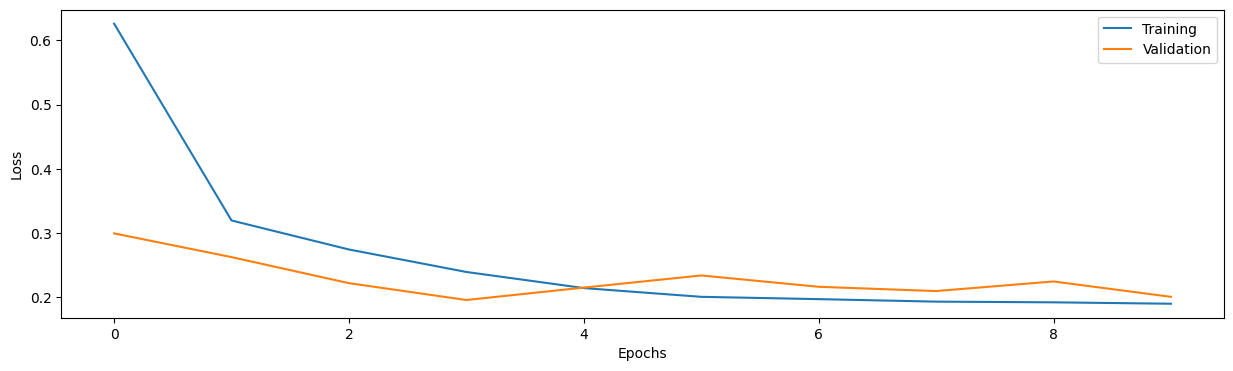

{'F1_score': 0.6024175535409275, 'accuracy': 0.9469122807017544, 'precision': 0.7646764509673115, 'recall': 0.4969650986342944}


In [29]:
import re
import pandas as pd
from io import StringIO
import os
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, random_split

from Dataload import pil_process_image_color, encode, CustomImageDataset
#from utils import train_network, pos_weight
#from metrics import compute_metrics
from sklearn.metrics import confusion_matrix
import torch
import numpy as np
from tqdm import tqdm

# Hyperparameters
batch_size = 512
lr = 0.001
# To remove class 12
#weights = torch.ones(19)
#weights[11] = 0

# Set device to GPU if this is available
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')

# Loading filenames and labels
# Assumes data is in folder "Dataset"
DATASET_PATH = "/content/Dataset/COMP5329S1A2Dataset/"
FILENAME_TRAIN = 'train.csv'
FILENAME_TEST = 'test.csv'

with open(DATASET_PATH + FILENAME_TRAIN) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
with open(DATASET_PATH + FILENAME_TEST) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
df_train.to_csv("train_labels_captions.csv")
df_test.to_csv("test_labels_captions.csv")

# To get overview
#print(df_test.describe)

# Defining transforms
INPUT_HEIGHT = 128
INPUT_WIDTH = 128
resize = transforms.Resize(size=(INPUT_HEIGHT,
        INPUT_WIDTH)) # Trying to resize to (INPUT_HEIGHT,INPUT_WIDTH)

# TODO: we can add data augmentation here
# See for example https://pyimagesearch.com/2021/10/04/image-data-loaders-in-pytorch/
# or here: https://docs.pytorch.org/vision/main/transforms.html
trainTransforms = transforms.Compose(
    [resize,transforms.RandomHorizontalFlip(),transforms.ToTensor()])
testTransforms = transforms.Compose([resize,transforms.ToTensor()])

# Create dataloaders
training_data = CustomImageDataset(df_train,DATASET_PATH+"data/",transform=trainTransforms,target_transform=encode)
test_data = CustomImageDataset(df_test,DATASET_PATH+"data/",transform=testTransforms,target_transform=None,targets_available=False)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data)

# Setup model
model = CNN().to(device)
weights = pos_weight(df_train,barplot=False).to(device)
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print('Model initialized.')

# Loading indices for 80/20 split of training data
train_idx = np.load("/content/subset_train_indices.npy")
validation_idx = np.load("/content/validation_indices.npy")
# Subset dataset for train and val
subset_train_dataset = Subset(training_data, train_idx)
validation_dataset = Subset(training_data, validation_idx)
subset_train_loader = DataLoader(subset_train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset)

# Training
log_interval = 100 # How often we print train loss
train_losses, test_losses = train_network(log_interval,model, device, subset_train_loader, validation_loader,optimizer, loss,epochs=10)

plt.figure(figsize=(15,4))
plt.plot(train_losses,label="Training")
plt.plot(test_losses,label="Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.show()

# Testing on validation set and get
test_loss, all_preds, all_targets = test(model, device, validation_loader, loss, target_available=True) # output predictions as tensors
all_preds = np.asarray([np.asarray(tensor.cpu()) for tensor in all_preds])
all_targets = np.asarray([np.asarray(tensor.cpu()) for tensor in all_targets])
metrics = compute_metrics(all_preds,all_targets)
print(metrics)

Model saved to /content/model_21_05_25_v1.pt
Model size: 55.10752582550049 MB


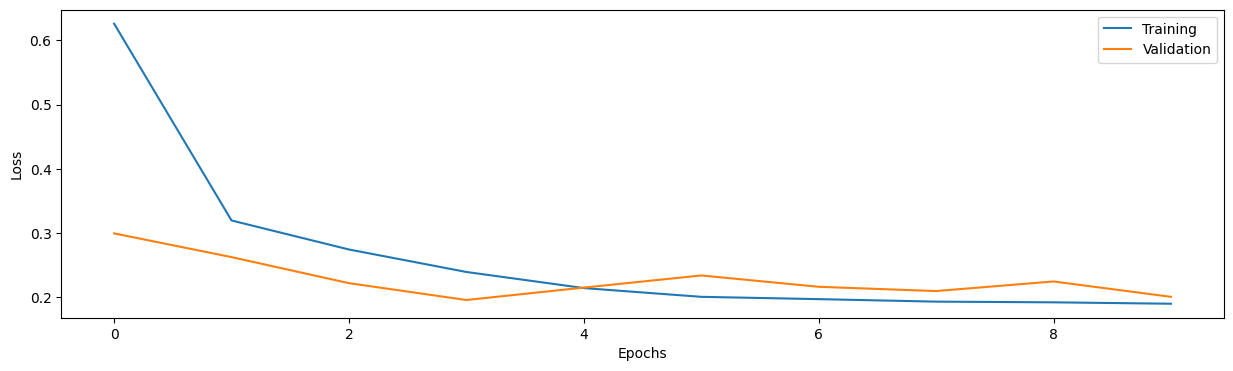

In [33]:
# save model, scores and plot and check size of model is under 100MB
model_name = "21_05_25_v1"

def get_model_size_mb(model):
    path = "temp_model.pth"
    torch.save(model.state_dict(), path)
    size_mb = os.path.getsize(path) / (1024 * 1024)
    os.remove(path)
    return size_mb

path_name_model = "/content/model_" + model_name+".pt"
path_name_plot = "/content/model_" + model_name + "loss.png"
path_name_scores = "/content/model_" + model_name + "scores.txt"

torch.save(model.state_dict(), path_name_model)
print(f"Model saved to {path_name_model}")
size_mb = os.path.getsize(path_name_model) / (1024 * 1024)
print(f"Model size: {size_mb} MB")

plt.figure(figsize=(15,4))
plt.plot(train_losses,label="Training")
plt.plot(test_losses,label="Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.savefig(path_name_plot)

import json
with open(path_name_scores, 'w') as file:
     file.write(json.dumps(metrics))

In [ ]:
# Compute predictions for true test set
test_pred = test(model, device, test_dataloader,loss,target_available=False)

In [ ]:
# Convert predictions to csv
from tqdm import tqdm
import numpy as np

def get_class(array):
  return np.where(array > 0.5)[1] +1

def unencode(y_pred):
  labels = []
  for i in tqdm(range(len(y_pred))):
    temp = y_pred[i].cpu()
    temp = np.asarray(temp)
    temp = get_class(temp)
    temp = " ".join(str(item) for item in temp)
    labels.append(temp)
  return labels

#cpu_preds = torch.tensor(val_pred, device =  'cpu')
pred_labels= unencode(test_pred)
pred_df = df_test.copy()
pred_df = pred_df.drop("Caption",axis=1)
pred_df["Labels"] = pred_labels
print("Submission dataframe:")
print(pred_df.describe)
submission_name = "/content/submission.csv"
pred_df.to_csv(submission_name,index=False)
print(f"/nPredictions saved as {submission_name}")

100%|██████████| 10000/10000 [00:00<00:00, 25031.74it/s]


1 8

<bound method NDFrame.describe of         ImageID Labels
0     30000.jpg      1
1     30001.jpg    1 8
2     30002.jpg      1
3     30003.jpg      1
4     30004.jpg    1 3
...         ...    ...
9995  39995.jpg       
9996  39996.jpg  1 3 4
9997  39997.jpg      1
9998  39998.jpg      1
9999  39999.jpg      1

[10000 rows x 2 columns]>


In [ ]:
# Submit predictions
! kaggle competitions submit -c multi-label-classification-competition-2025 -f /content/submission.csv -m "first submission"

100% 120k/120k [00:00<00:00, 710kB/s]
Successfully submitted to Multi-label Classification Competition 2025